##### TRAN Minh-Quan

##### M1 MINT

# TP 2 : Prédiction des critiques de films

## But du TP : A partir d’une critique de film, nous allons implanter des modèles qui vont tenter de prédire si elle est positive ou négative. Ceci est une tâche de classification binaire.

In [2]:
# à lancé dans le terminal : 

#conda install -c conda-forge keras
#conda install -c anaconda nltk

## Chargement des libraries :

In [1]:
import warnings
warnings.filterwarnings("ignore") 

import numpy as np
import pandas as pd

import nltk    #Natural language processing tool-kit
nltk.download('stopwords')
  
from nltk.corpus import stopwords                   #Stopwords corpus

from keras.datasets import imdb
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer, TfidfTransformer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB, GaussianNB
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import accuracy_score

[nltk_data] Downloading package stopwords to C:\Users\Minh-
[nltk_data]     Quan\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Using TensorFlow backend.


# Partie 1 :

## Import des données

In [2]:
filename = "./sentiment_labelled_sentences/imdb_labelled.txt"

df = pd.read_csv(filename, sep="\t")
df.columns = ["sentence", "label"]

- Regardons la taille des données :

In [3]:
print("shape", df.shape)

shape (747, 2)


- Résumé des données :

In [5]:
df.head()

,sentence,label
0,Not sure who was more lost - the flat characte...,0
1,Attempting artiness with black & white and cle...,0
2,Very little music or anything to speak of.,0
3,The best scene in the movie was when Gerardo i...,1
4,"The rest of the movie lacks art, charm, meanin...",0


- Vérifions le balancement des données :

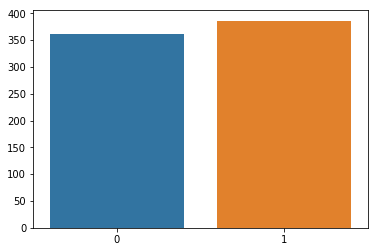

In [6]:
sns.barplot(np.unique(df['label']),df.groupby('label').count().values[:,0])

On remarque sur le graphique ci-dessus qu'il y a à peu près autant de label 0 (avis négatif) que de label 1 (avis positif) donc nos données sont bien balancées.

## Bag of words 

### Sur un sous-jeu de données

Avant d'étudier l'ensemble de nos données en entier, nous allons commencer par étudier seulement une petite sous-partie des données pour regarder ce qu'il se passe.

- Pour cela, on va commencer par prendre les 10 premiers textes : 

In [7]:
X_sub = df['sentence'][0:10]

- Affichons les 10 premiers textes : 

In [8]:
X_sub

0    Not sure who was more lost - the flat characte...
1    Attempting artiness with black & white and cle...
2         Very little music or anything to speak of.  
3    The best scene in the movie was when Gerardo i...
4    The rest of the movie lacks art, charm, meanin...
5                                  Wasted two hours.  
6    Saw the movie today and thought it was a good ...
7                                 A bit predictable.  
8    Loved the casting of Jimmy Buffet as the scien...
9                 And those baby owls were adorable.  
Name: sentence, dtype: object

Remarque : Chaque texte est représenté par une phrase qui décris l'avis d'une personne sur un film.

Ensuite à partir de nos 10 textes, on va construire un premier dictionnaire qui regroupe tous les différents mots présents dans les 10 textes : 

- On crée un dictionnaire, puis on compte le nombre d'apparition des mots du dictionnaire dans chaque texte (critique)

In [9]:
count_vect = CountVectorizer()
X_sub_counts = count_vect.fit_transform(X_sub)
dictionary_sub   = count_vect.get_feature_names()
print(dictionary_sub)

['about', 'acting', 'adorable', 'almost', 'and', 'angles', 'anything', 'art', 'artiness', 'as', 'attempting', 'audience', 'baby', 'became', 'because', 'best', 'bit', 'black', 'buffet', 'camera', 'casting', 'characters', 'charm', 'clever', 'disappointed', 'effort', 'emptiness', 'empty', 'even', 'existent', 'find', 'flat', 'for', 'gerardo', 'good', 'guess', 'half', 'head', 'his', 'hours', 'if', 'in', 'is', 'it', 'jimmy', 'keeps', 'kids', 'lacks', 'lines', 'little', 'lost', 'loved', 'meaning', 'messages', 'more', 'movie', 'music', 'nearly', 'non', 'not', 'of', 'or', 'out', 'owls', 'plot', 'poor', 'predictable', 'rest', 'ridiculous', 'running', 'saw', 'scene', 'science', 'song', 'speak', 'sure', 'teacher', 'that', 'the', 'those', 'thought', 'through', 'to', 'today', 'trying', 'two', 'very', 'walked', 'was', 'wasted', 'were', 'when', 'white', 'who', 'whom', 'with', 'works']


On obtient donc ci-dessus une liste qui contient tous les mots différents présents dans les 10 textes et classés par ordre alphabétique.

In [10]:
print(count_vect.vocabulary_.get(u'who'))

93


Une fois le dictionnaire construit, on peut afficher le nombre d'apparition de chaque mot du dictionnaire pour un texte donné.

Regardons par exemple pour le 1er texte : 

In [11]:
print(X_sub_counts.toarray()[0,:])

[0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 1 0 0 0 0 1
 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 1 0 0 1 0 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0
 0 1 0 0 2 0 0 0 0 0 0 0 0 1 1 0 0 0 0 1 1 0 0]


On remarque que ce n'est pas pratique pour connaître la position des mots qui apparaissent au moins une fois. 

De plus les 0 représentent les mots qui n'apparaissent pas dans le texte donné, donc c'est inutile de les afficher car si on étudie des données très grandes, cela deviendrait trop lourd d'afficher tous les 0 et cela prendrait beaucoup de mémoire pour rien.

- Pour remédier à cela, on va construire une matrice sparse qui ne prendra pas en compte les 0, c'est-à-dire les mots qui n'apparaissent pas :

In [12]:
print(X_sub_counts.shape) 
print(X_sub_counts[0])  # matrice 10 ligne taille dictio, dans chaque ligne 0 ou 1
print(type(X_sub_counts)) # hauteur 10 largeur 97 (10 phrases, 97 mots dans le dictio)

(10, 97)
  (0, 62)	1
  (0, 87)	1
  (0, 94)	1
  (0, 60)	1
  (0, 36)	1
  (0, 57)	1
  (0, 11)	1
  (0, 61)	1
  (0, 21)	1
  (0, 31)	1
  (0, 78)	2
  (0, 50)	1
  (0, 54)	1
  (0, 88)	1
  (0, 93)	1
  (0, 75)	1
  (0, 59)	1
<class 'scipy.sparse.csr.csr_matrix'>


On voit bien ci-dessus qu'on conserve bien que la place des non 0 en memoire.

Nous avons donc dans notre cas la position de tous les mots qui apparaissent au moins une fois dans le 1er texte, ainsi que leur nombre d'apparition (représenté par le nombre dans la colonne de droite).

Vérifions par exemple pour le mot à la 78 ème position qui est censé apparaitre 2 fois dans le 1er texte d'après les résultats ci-dessus :

In [13]:
X_sub[0]

'Not sure who was more lost - the flat characters or the audience, nearly half of whom walked out.  '

In [14]:
dictionary_sub[78]

'the'

On voit que c'est le mot "the" qui apparait 2 fois dans le 1er texte ce qui est vrai.

Essayons encore avec un autre mot : 

In [15]:
dictionary_sub[11]

'audience'

Le mot "audience" apparait bien une seule fois dans le 1er texte.

- Nous allons maintenant afficher l'histogramme représentant par exemple les 20 mots qui apparaissent le plus ainsi que leur nombre d'apparition : 

In [16]:
word_counts = pd.DataFrame(X_sub_counts.toarray(),columns = dictionary_sub)
word_total_counts = pd.DataFrame()
word_total_counts['count'] = word_counts.sum(axis=0)
word_total_counts['word'] = dictionary_sub

In [17]:
word_total_counts_sorted_top  = word_total_counts.sort_values(by="count",ascending = False).iloc[0:20]

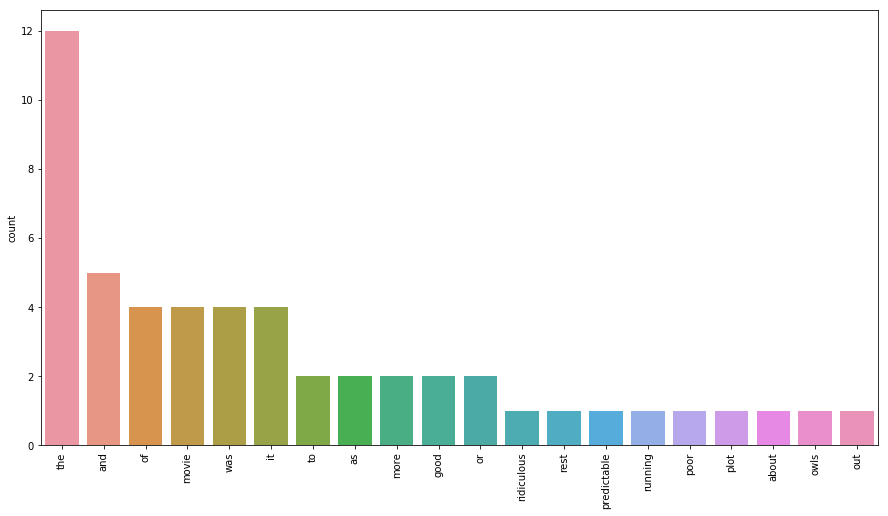

In [18]:
plt.figure(figsize=(15,8))
sns.barplot(x = word_total_counts_sorted_top.index,y=word_total_counts_sorted_top['count'])
plt.xticks(rotation=90,fontsize=10)
plt.show()

On obtient donc un histogramme pour les 20 mots qui apparaissent le plus, le nombre d'apparition étant par ordre décroissant (à gauche le plus présent).

Le mot "the" apparait le plus, 12 fois en tout dans les 10 textes, ensuite vient le mot "and" qui apparait 5 fois. Tous les mots après le mot "or" n'apparaissent qu'une seule fois.

On peut remarquer que parmi ces 20 mots qui apparaissent le plus, la plupart sont des pronoms, conjonctions ou prépositions ce qui nous apportent aucune information. On verra plus tard comment les enlever. 

Pareil pour le mot "movie" qui nous renseigne rien puisque tous les textes sont des avis de spectateur sur un film. Au contraire, les mots comme "ridiculous" ou encore "good" sont très intéressant puisque ce sont des adjectifs qui décrivent un film.




On peut aussi définir une fonction qui prend en encapsule ce qui précède :

In [21]:
def most_frequent_words(count_vect,data):    
    data_counts = count_vect.fit_transform(data)
    dictionary   = count_vect.get_feature_names()
    print("Taille du dictionnaire : ",len(dictionary))
    word_counts = pd.DataFrame(data_counts.toarray(),columns = dictionary)
    word_total_counts = pd.DataFrame()
    word_total_counts['count'] = word_counts.sum(axis=0)
    word_total_counts['word'] = dictionary
    word_total_counts_sorted_top  = word_total_counts.sort_values(by="count",ascending = False).iloc[0:20]
    plt.figure(figsize=(15,8))
    sns.barplot(x = word_total_counts_sorted_top.index,y=word_total_counts_sorted_top['count'])
    plt.xticks(rotation=90,fontsize=10)
    plt.show()
    return {'data_counts' : data_counts, 'word_total_counts' :word_total_counts, 'dictionary' : dictionary}

In [24]:
count_vect = CountVectorizer()
X_sub_counts = count_vect.fit_transform(X_sub)

Taille du dictionnaire :  97


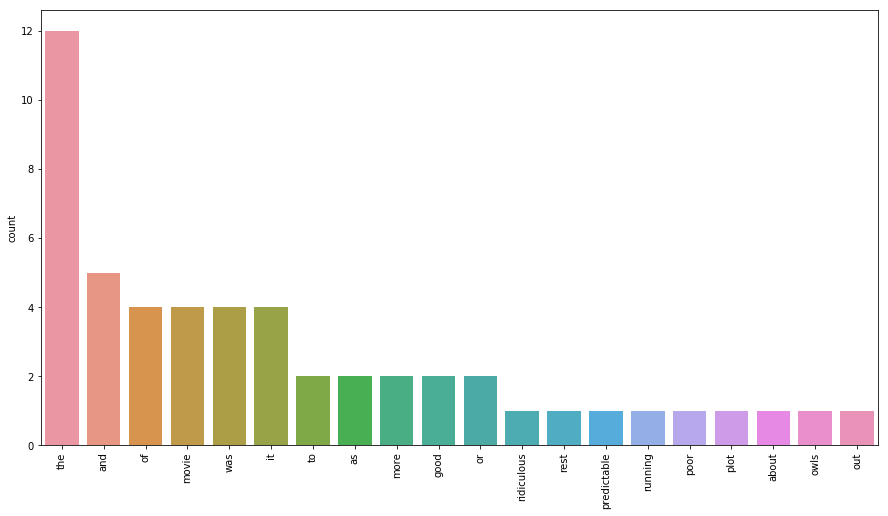

In [25]:
most_frequent_words_sub = most_frequent_words(count_vect,X_sub)

### Passage aux données complètes

On recommence la même étude qu'au dessus mais cette fois-ci avec tout le corpus.

In [26]:
X = df['sentence'] # données complètes

Taille du dictionnaire :  3044


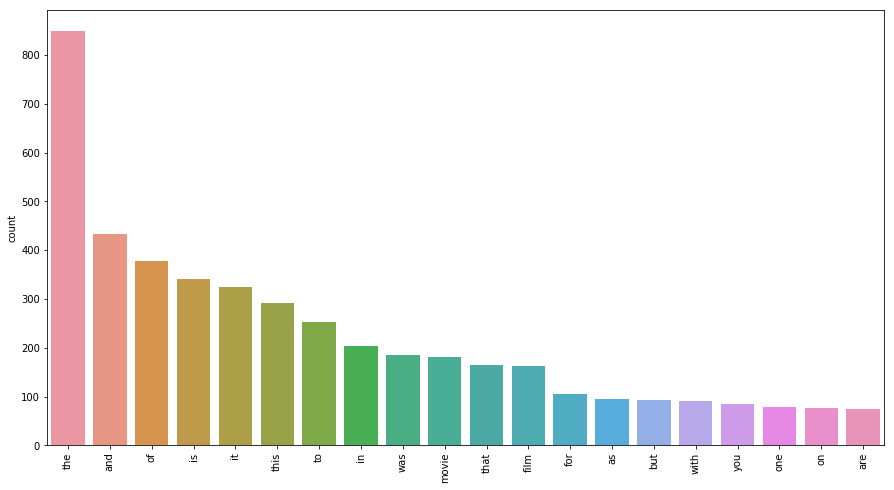

In [27]:
most_frequent_words_tot = most_frequent_words(count_vect,X)

Quels problèmes voyez-vous ?

Le problème ici est celui évoquer dans la partie avant : on remarque que parmi les 20 mots qui apparaissent le plus, la plupart sont des pronoms, conjonctions ou prépositions 
On va clairemant enlever ces mots qui sont trop fréquents et qui nous apportent aucune information.

## Préparation des données

Cette étape peut être extrêmement longue mais ici on utilise une liste déjà faite : "stopword" .

### Miniscules UTF-8 sans ponctuation

Il faut faire attention dès le départ à ce que dans nos données/textes sont écrits en minuscule, en UTF-8 et sans ponctuation car le programme peut considérer 2 mots différents alors que en vrai ce sont les mêmes mots à un accent près par exemple.

### Stopwords

Nous utilisons ici "stopwords" qui nous fournit directement une liste déjà faite contenant les mots qui apparaissent très souvent dans toutes les phrases mais qui nous apportent aucune information. Ce sont donc les mots qu'on enlèvera et qu'on n'étudiera pas.

In [28]:
stop = set(stopwords.words('english')) 
print(stop)

{'mightn', 're', 'before', 'until', "should've", "mightn't", 'his', 'aren', 'she', 'off', 'their', "don't", 'doing', 'but', 'how', 'should', "you'll", 'be', 'theirs', 'few', 'you', "haven't", 'both', 'can', "won't", 'yourselves', "wasn't", 'by', 'won', 'between', 'about', 'themselves', 'needn', 'out', 'once', 'than', 'what', 'above', 'under', 'were', 'yourself', 'or', 'now', 'isn', 'there', 'didn', 'me', 'haven', "isn't", 'too', 'in', 'to', "hadn't", 'any', 'whom', 'having', "you've", 'own', 'very', 'here', 'ours', 'my', "shouldn't", 'are', "couldn't", 'm', 'will', 'over', 've', 'an', 'ourselves', 'your', 'am', 'is', 'with', 'for', 'at', 'being', 'through', 'only', "shan't", 'o', "weren't", 'a', "needn't", 'll', 'most', 'he', 'no', "aren't", 'after', 'ma', 'was', 'been', 'more', 'him', "mustn't", 'up', "doesn't", "that'll", 'we', 'her', 's', 'ain', 'shan', 'where', 'some', 'same', 'y', 'who', 'our', "hasn't", 'i', 'its', 'have', 'wasn', 'because', 'this', 'wouldn', 'couldn', 'they', 'h

On peut aussi par exemple rajouter à cette liste les mots "movie" et "film" car on a vu qu'ils étaient pas intéressant pour connaitre l'avis d'un film dans le cas de notre étude et parce qu'ils apparaissent beaucoup de fois :

In [29]:
stop.update({'movie','film'})

Vérifions que le mot "movie" a bien été ajouté à la liste de stopwords :

In [30]:
'movie' in stop

True

In [31]:
'film' in stop

True

Renvoie True donc désormais "movie" et "film" appartiennent aussi à la liste de stopwords.

Après avoir enlever tous les mots inutiles grâce à la liste stopwords, on peut afficher l'histogramme réprésentant le nombre d'apparition des mots restant qui apparaissent le plus dans le corpus :

In [32]:
count_vect_sw = CountVectorizer(stop_words=stop)

Taille du dictionnaire :  2911


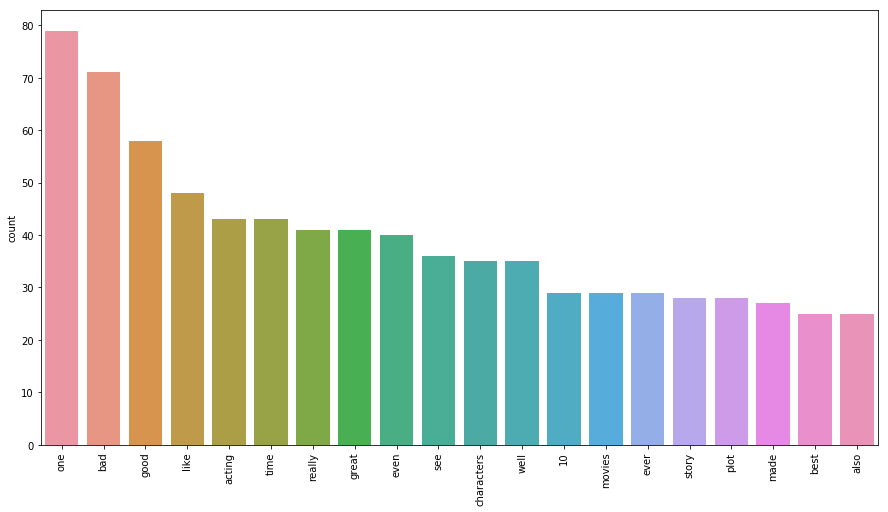

In [33]:
most_frequent_words_sw = most_frequent_words(count_vect_sw,X)

On obtient donc un histogramme qui nous donne des mots beaucoup plus intéressant pour les avis des films comme "bad", "good", "like" etc . Cependant il reste des mots qui nous apportent rien comme "movies" (au pluriel), "story". On pourrait aussi les enlever mais ça nous gêne moins si on les laisse car on a déjà enlevé la plupart des mots qu'on voulait grâce à la liste stopwords.

Remarque : On est passé d'un dictionnaire initialement à 3044 mots, à un dictionnaire à 2911 mots après avoir fait un peu le tri avec la liste stopwords.

### Visualisation du corpus

In [34]:
most_frequent = np.array(most_frequent_words_sw['data_counts'].toarray())
hist = most_frequent / most_frequent.sum(axis=1)[:,None] # ... / divise par ligne , proportion des mots

In [35]:
hist[np.argsort(df['label']),:]

array([[0. , 0. , 0. , ..., 0. , 0. , 0. ],
       [0. , 0. , 0. , ..., 0. , 0. , 0. ],
       [0. , 0. , 0. , ..., 0. , 0. , 0. ],
       ...,
       [0.4, 0. , 0. , ..., 0. , 0. , 0. ],
       [0. , 0. , 0. , ..., 0. , 0. , 0. ],
       [0. , 0. , 0. , ..., 0. , 0. , 0. ]])

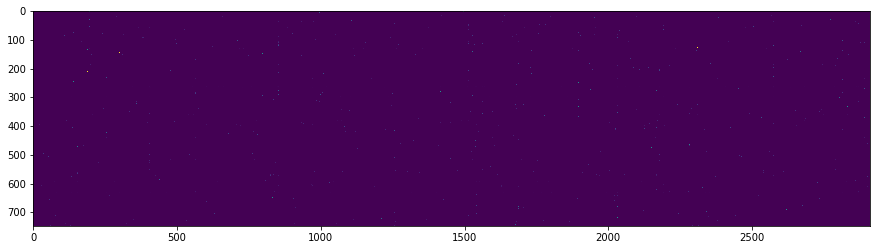

In [36]:
plt.figure(figsize=(15,8))
plt.imshow(hist[np.argsort(df['label']),:])
#plt.colorbar()

La figure est censé réprésenter la visualisation de notre corpus, avec en ordonné les textes et en abscisse les mots du dictionnaire. La couleur violet représente l'abscence d'un mot pour un texte donné et les points montrent la présence d'un mot pour les différents textes.

Cependant on ne voit pas grand chose au niveau des points et de leur couleur qui est censé représenter le nombre d'apparition du mot en question.

Donc essayons d'utiliser une autre méthode pour mieux visualiser notre corpus.




### Avec TF_IDF

#### Principe du TF_IDF : 

C'est une mesure statistique qui permet d'évaluer l'importance d'un terme contenu dans un document.

Pour cela on commence d'abord par calculer le TF des mots qui est la fréquence de chaque mot dans le corpus (nombre d'apparition sur nombre totale de mot).

Ensuite on calcule l'IDF qui est la fréquence inverse de document et qui représente une mesure de l'importance du terme dans l'ensemble du corpus. Dans la méthode TF_IDF, elle vise à donner un poids plus important aux termes les moins fréquents, considérés comme plus discriminants.

Et enfin, en multipliant le TF et l'IDF, on obtient le TF_IDF qui nous donne le poids des mots. Le poids augmente proportionnellement avec le nombre d'apparition du mot dans le corpus. Il varie également en fonction de la fréquence du mot dans le corpus

In [81]:
transformer = TfidfTransformer(smooth_idf=False)
transformer

TfidfTransformer(norm='l2', smooth_idf=False, sublinear_tf=False,
         use_idf=True)

In [82]:
tf_idf_transf = transformer.fit_transform(most_frequent_words_sw['data_counts'])

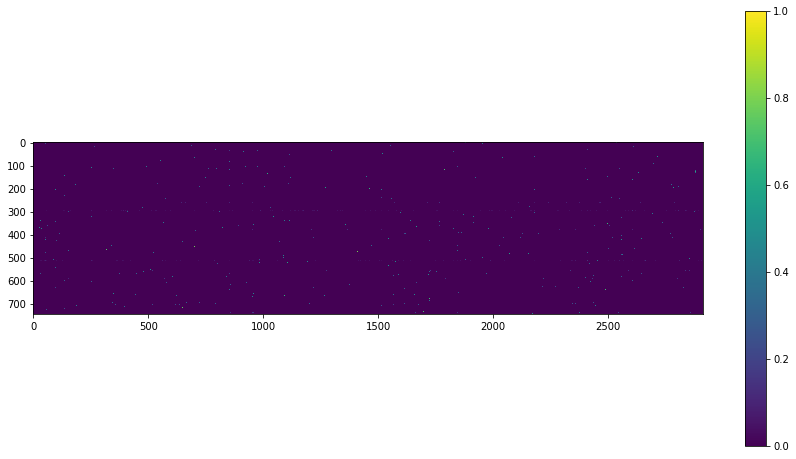

In [83]:
plt.figure(figsize=(15,8))
plt.imshow(tf_idf_transf.toarray()[np.argsort(df['label']),:])
plt.colorbar()

Avec la méthode TF_IDF, on obtient une figure un peu plus clair qu'avant. En effet, on aperçoit mieux les points ainsi que leur couleur. Les points jaunes représentent les mots qui apparaissent le plus et au contraire les points bleu foncé représentent ceux qui apparaissent le moins (violet signifie que le mot n'apparait pas du tout).

## Apprentissage supervisé

### Sur les counts

In [40]:
NB_counts = MultinomialNB()
NB_counts.fit(X=most_frequent_words_sw['data_counts'],y=df['label'])
accuracy_score(NB_counts.predict(most_frequent_words_sw['data_counts']),df['label'])

0.9665327978580991

On obtient une précision de 96% ce qui est très bon.

### Sur le TF-IDF

In [41]:
NB_tfidf = GaussianNB()
NB_tfidf.fit(X=tf_idf_transf.toarray(),y=df['label'])
accuracy_score(NB_tfidf.predict(tf_idf_transf.toarray()),df['label'])

0.9665327978580991

On obtient la même précision.

In [42]:
df['prediction_counts'] = NB_counts.predict(most_frequent_words_sw['data_counts'])

In [43]:
df['prediction_tfidf'] = NB_tfidf.predict(tf_idf_transf.toarray())

In [44]:
df[df['prediction_tfidf'] != df['label']]

,sentence,label,prediction_counts,prediction_tfidf
23,Give this one a look.,1,1,0
38,I don't think you will be disappointed.,1,0,0
58,A great film by a great director.,1,1,0
63,10/10,1,1,0
163,Everything from acting to cinematography was s...,1,1,0
250,"I won't say any more - I don't like spoilers, ...",1,0,0
293,But this movie really got to me.,1,1,0
294,See it.,1,1,0
312,The cast is good.,1,1,0
332,the cast was great.,1,1,0


Avec le TF-IDF, nous avons seulement 25 erreurs sur toutes nos données d'où la précision de 96%.

In [45]:
df[df['prediction_counts'] != df['label']]

,sentence,label,prediction_counts,prediction_tfidf
20,If there was ever a movie that needed word-of-...,1,0,1
38,I don't think you will be disappointed.,1,0,0
49,The directing and the cinematography aren't qu...,0,1,0
76,"I saw ""Mirrormask"" last night and it was an un...",0,1,0
123,Highly unrecommended.,0,1,0
131,There were too many close ups.,0,1,0
142,It even has its sweet moments.,1,0,1
175,"If you see it, you should probably just leave ...",0,1,0
235,1/10 - and only because there is no setting fo...,0,1,0
244,The last 15 minutes of movie are also not bad ...,1,0,1


Pareil sur le count, 25 erreurs sur toutes les données d'où la même précision.

In [47]:
NB_logistic = SGDClassifier(loss='hinge', penalty='l2',\
                           alpha=1e-3, random_state=42,\
                           max_iter=5, tol=None)
logistic_fit = NB_logistic.fit(X=tf_idf_transf.toarray(),y=df['label'])
accuracy_score(NB_logistic.predict(tf_idf_transf.toarray()),df['label'])

0.9879518072289156

On obtient avec le classifieur de descente de gradient stochastique une précision encore meilleure que précédemment : 98,79%.

In [48]:
print("Mots avec le coeff le plus négatif : ", most_frequent_words_sw['dictionary'][np.argsort(NB_logistic.coef_)[0][0]])
print("Mots avec le coeff le plus positif : ", most_frequent_words_sw['dictionary'][np.argsort(NB_logistic.coef_)[0][-1]])

Mots avec le coeff le plus négatif :  bad
Mots avec le coeff le plus positif :  beautiful


Donc le mot le plus prédictive pour le label 1 (avis positif) est le mot : wonderful.

Le mot le plus prédictive pour le label 0 (avis négatif) est le mot : bad.


### Avec une pipeline

In [49]:
from sklearn.pipeline import Pipeline
text_clf = Pipeline([('vect', CountVectorizer()), ('tfidf', TfidfTransformer()), ('clf', SGDClassifier(loss='hinge', penalty='l2',\
                           alpha=1e-3, random_state=42,\
                           max_iter=5, tol=None)),])

In [50]:
text_clf.fit(X,df['label'])#
accuracy_score(text_clf.predict(X),df['label'])

0.9825970548862115

On obtient une précision de 98,25% avec une pipeline ce qui est meilleur que sur le count ou le TF_IDF mais un tout petit peu moins bon que le classifieur SGDC.

# Partie 2 :

# Jeu de données complet

Dataset of 25,000 movies reviews from IMDB, labeled by sentiment (positive/negative). Reviews have been preprocessed, and each review is encoded as a sequence of word indexes (integers). For convenience, words are indexed by overall frequency in the dataset, so that for instance the integer "3" encodes the 3rd most frequent word in the data. This allows for quick filtering operations such as: "only consider the top 10,000 most common words, but eliminate the top 20 most common words".

## Objectif : 

Dans cette tâche, à partir d’une critique de film, le modèle tente de prédire si elle est positive ou négative. Ceci est une tâche de classification binaire.

Dans cette partie, ce qui change est le fait que chaque mot est associé à un nombre entier en fonction de leur nombre d'apparition au total dans tous les textes. Par exemple l'entier "1" est associé au 1er mot le plus fréquent dans tous les données, l'entier "2" au 2ème mot le plus fréquent ect .

Ci-dessous, nous voyons bien que chaque mot est associé à un entier : 

In [51]:
imdb.get_word_index()

{'fawn': 34701,
 'tsukino': 52006,
 'nunnery': 52007,
 'sonja': 16816,
 'vani': 63951,
 'woods': 1408,
 'spiders': 16115,
 'hanging': 2345,
 'woody': 2289,
 'trawling': 52008,
 "hold's": 52009,
 'comically': 11307,
 'localized': 40830,
 'disobeying': 30568,
 "'royale": 52010,
 "harpo's": 40831,
 'canet': 52011,
 'aileen': 19313,
 'acurately': 52012,
 "diplomat's": 52013,
 'rickman': 25242,
 'arranged': 6746,
 'rumbustious': 52014,
 'familiarness': 52015,
 "spider'": 52016,
 'hahahah': 68804,
 "wood'": 52017,
 'transvestism': 40833,
 "hangin'": 34702,
 'bringing': 2338,
 'seamier': 40834,
 'wooded': 34703,
 'bravora': 52018,
 'grueling': 16817,
 'wooden': 1636,
 'wednesday': 16818,
 "'prix": 52019,
 'altagracia': 34704,
 'circuitry': 52020,
 'crotch': 11585,
 'busybody': 57766,
 "tart'n'tangy": 52021,
 'burgade': 14129,
 'thrace': 52023,
 "tom's": 11038,
 'snuggles': 52025,
 'francesco': 29114,
 'complainers': 52027,
 'templarios': 52125,
 '272': 40835,
 '273': 52028,
 'zaniacs': 52130,

- Commençons par séparer nos données en 2, 50% des données seront des données d'entraînement et les 50% autres serviront de données de test :

In [52]:
(X_train, y_train), (X_test, y_test) = imdb.load_data() 

### Les textes ont été hashés

Regardons par exemple pour le 1er texte : 

In [53]:
print(X_train[0])

[1, 14, 22, 16, 43, 530, 973, 1622, 1385, 65, 458, 4468, 66, 3941, 4, 173, 36, 256, 5, 25, 100, 43, 838, 112, 50, 670, 22665, 9, 35, 480, 284, 5, 150, 4, 172, 112, 167, 21631, 336, 385, 39, 4, 172, 4536, 1111, 17, 546, 38, 13, 447, 4, 192, 50, 16, 6, 147, 2025, 19, 14, 22, 4, 1920, 4613, 469, 4, 22, 71, 87, 12, 16, 43, 530, 38, 76, 15, 13, 1247, 4, 22, 17, 515, 17, 12, 16, 626, 18, 19193, 5, 62, 386, 12, 8, 316, 8, 106, 5, 4, 2223, 5244, 16, 480, 66, 3785, 33, 4, 130, 12, 16, 38, 619, 5, 25, 124, 51, 36, 135, 48, 25, 1415, 33, 6, 22, 12, 215, 28, 77, 52, 5, 14, 407, 16, 82, 10311, 8, 4, 107, 117, 5952, 15, 256, 4, 31050, 7, 3766, 5, 723, 36, 71, 43, 530, 476, 26, 400, 317, 46, 7, 4, 12118, 1029, 13, 104, 88, 4, 381, 15, 297, 98, 32, 2071, 56, 26, 141, 6, 194, 7486, 18, 4, 226, 22, 21, 134, 476, 26, 480, 5, 144, 30, 5535, 18, 51, 36, 28, 224, 92, 25, 104, 4, 226, 65, 16, 38, 1334, 88, 12, 16, 283, 5, 16, 4472, 113, 103, 32, 15, 16, 5345, 19, 178, 32]


On voit bien que le texte est composé uniquement d'entier à la place de mot.

In [54]:
print(y_train[0]) # Vaut 1 donc le 1er test est un avis positif

1


Le 1er texte a pour label 1 ce qui signifie que c'est un avis positif. En effet, le label 0 correspond à un avis négatif d'un film et 1 correspond à un avis positif.

Nous pouvons tout de même ré-afficher les mots correspondant, par exemple toujours pour le 1er texte on a les mots suivant qui sont présents dans ce texte : 

In [55]:
word2id = imdb.get_word_index()
id2word = {i: word for word, i in word2id.items()}
print([id2word.get(i, ' ') for i in X_train[0]])

['the', 'as', 'you', 'with', 'out', 'themselves', 'powerful', 'lets', 'loves', 'their', 'becomes', 'reaching', 'had', 'journalist', 'of', 'lot', 'from', 'anyone', 'to', 'have', 'after', 'out', 'atmosphere', 'never', 'more', 'room', 'titillate', 'it', 'so', 'heart', 'shows', 'to', 'years', 'of', 'every', 'never', 'going', 'villaronga', 'help', 'moments', 'or', 'of', 'every', 'chest', 'visual', 'movie', 'except', 'her', 'was', 'several', 'of', 'enough', 'more', 'with', 'is', 'now', 'current', 'film', 'as', 'you', 'of', 'mine', 'potentially', 'unfortunately', 'of', 'you', 'than', 'him', 'that', 'with', 'out', 'themselves', 'her', 'get', 'for', 'was', 'camp', 'of', 'you', 'movie', 'sometimes', 'movie', 'that', 'with', 'scary', 'but', 'pratfalls', 'to', 'story', 'wonderful', 'that', 'in', 'seeing', 'in', 'character', 'to', 'of', '70s', 'musicians', 'with', 'heart', 'had', 'shadows', 'they', 'of', 'here', 'that', 'with', 'her', 'serious', 'to', 'have', 'does', 'when', 'from', 'why', 'what', 

Regardons les 50 mots les plus fréquents : 

In [56]:
def getKeysByValue(dictOfElements, valueToFind):
    listOfKeys = list()
    listOfItems = dictOfElements.items()
    for item  in listOfItems:
        if item[1] == valueToFind:
            listOfKeys.append(item[0])
    print(listOfKeys)

In [57]:
for word_num in np.arange(50): # Ici on affiche les 50 mots les plus fréquents du dictionnaire de l'ensemble des textes
     getKeysByValue(imdb.get_word_index(),word_num) 

[]
['the']
['and']
['a']
['of']
['to']
['is']
['br']
['in']
['it']
['i']
['this']
['that']
['was']
['as']
['for']
['with']
['movie']
['but']
['film']
['on']
['not']
['you']
['are']
['his']
['have']
['he']
['be']
['one']
['all']
['at']
['by']
['an']
['they']
['who']
['so']
['from']
['like']
['her']
['or']
['just']
['about']
["it's"]
['out']
['has']
['if']
['some']
['there']
['what']
['good']


Comme expliquer dans la première partie du TP, on voit ici que parmi les 50 mots les plus fréquents, la plupart sont des pronoms, conjonctions ou prépositions ce qui nous apportent aucune information.

On va donc par la suite choisir d'enlever par exemple ces 50 mots les plus fréquent car ils ne nous apportent aucune information sur la critique du film.

- Pour appliquer les différents modèles, il faut que tous les textes soient de la même taille.


In [58]:
print('Taille du plus petit texte: {}'.format(
len(min((X_test + X_test), key=len))))

Taille du plus petit texte: 14


In [59]:
print('Taille du plus grand texte: {}'.format(
len(max((X_train + X_test), key=len))))

Taille du plus grand texte: 2697


On remarque évidemment que les textes ont des tailles (en mots) variables et qu'ils ne sont pas tous de la même taille.

- Traçons une boîte à moustache afin d'avoir un résumé des tailles des différents textes issus de nos données : 

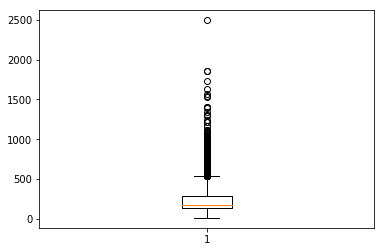

In [60]:
text_len = [len(X_train[i]) for i in range(len(X_train))]
plt.boxplot(text_len)
plt.show()

On remarque d'après le boxplot que plus de 95 % des textes n'ont pas une longueur supérieure à 500 mots. 

Donc par la suite, nous allons fixer une taille maximale de 500 pour tous les textes. Les textes ayant une taille plus grande que 500 seront coupés à partir de 500 mots et ceux qui ont une taille plus petit que 500, on les complétera avec des entiers nuls (0) (on utilisera la fonction pad_sequences() présent dans Keras).

- Redéfinissons nos données pour la suite : 

In [61]:
(X_train, y_train), (X_test, y_test) = imdb.load_data(num_words=5000, skip_top=50)

On a introduit les paramètres suivants : 

- "num_words=5000" qui signifie qu'on va seulement considérer les 5000 mots les plus courant. En effet, il y a plus de 80 000 mots différents dans les données donc on peut imaginer que les derniers mots les moins courant ne sont pas intéressant pour étudier l'avis d'un film puisqu'ils ne reviennent pas souvent dans les textes.


- "skip_top=50" qui signifie qu'on ne prend pas en compte les 50 mots les plus fréquents puisqu'ils ne nous apportent pas d'information.

In [62]:
from keras.preprocessing import sequence

max_words = 500
X_train = sequence.pad_sequences(X_train, maxlen=max_words)
X_test = sequence.pad_sequences(X_test, maxlen=max_words)

Ci-dessus on a fixé la limite de tous les textes à 500.

## Apprentissage supervisé

### Modèle Multinomial Naive Bayes

#### Sur les counts :

In [63]:
from sklearn.naive_bayes import MultinomialNB
import sklearn
from sklearn.datasets import load_files

In [64]:
nb_classifier = MultinomialNB()
nb_classifier.fit(X_train, y_train)
accuracy_score(nb_classifier.predict(X_train),y_train)

0.5124

#### Sur le TF-IDF :

(Voir Partie 1 pour l'explication du TF-IDF)

In [65]:
tf_idf_transf = transformer.fit_transform(X_train)

In [66]:
NB_tfidf = GaussianNB()
NB_tfidf.fit(tf_idf_transf.toarray(),y_train)
accuracy_score(NB_tfidf.predict(tf_idf_transf.toarray()),y_train)

0.51792

### Avec le classifieur de descente de gradient stochastique :

In [67]:
NB_logistic = SGDClassifier(loss='hinge', penalty='l2',\
                           alpha=1e-3, random_state=42,\
                           max_iter=5, tol=None)
logistic_fit = NB_logistic.fit(X=tf_idf_transf.toarray(),y=y_train)
accuracy_score(NB_logistic.predict(tf_idf_transf.toarray()),y_train)

0.53332

- Je pense qu'il y a un problème qui vient des paramètres du fit car on obtient des précisions relativement faible (51%) alors qu'on devrait avoir des % aux alentours de 80% voir plus.

Maintenant nous pouvons étudier d'autres modèles plus compliqué mais plus précis :

### Modèle simple de perceptron multicouche avec une seule couche cachée :

In [71]:
from keras import Sequential
from keras.layers import Embedding, LSTM, Dense, Dropout
from keras.layers import Flatten

In [77]:
top_words=5000

In [80]:
# Création du modèle
model = Sequential()
model.add(Embedding(top_words, 32, input_length=max_words))
model.add(Flatten())
model.add(Dense(250, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 500, 32)           160000    
_________________________________________________________________
flatten_1 (Flatten)          (None, 16000)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 250)               4000250   
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 251       
Total params: 4,160,501
Trainable params: 4,160,501
Non-trainable params: 0
_________________________________________________________________
None


On entraîne le modèle en prenant comme paramètre : 2 époques et 128 pour la taille du lot : 

In [107]:
model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=2, batch_size=128, verbose=2)

Train on 25000 samples, validate on 25000 samples
Epoch 1/2
 - 28s - loss: 0.5808 - acc: 0.6580 - val_loss: 0.3415 - val_acc: 0.8499
Epoch 2/2
 - 27s - loss: 0.2380 - acc: 0.9033 - val_loss: 0.2881 - val_acc: 0.8789


In [108]:
# Final evaluation of the model
scores = model.evaluate(X_test, y_test, verbose=0)
print("Accuracy: %.2f%%" % (scores[1]*100))

Accuracy: 87.89%


Nous avons ici une précision de prédiction égal à 87.89% ce qui est très bien.

Pour obtenir une meilleur précision, il faudrait jouer avec les paramètres.

### Modèle RNN avec 1 couche dense, 1 embedding et 1 LSTM(Long Short Term Memory): 

In [158]:
from keras import Sequential
from keras.layers import Embedding, LSTM, Dense, Dropout

"""
embedding_size=32
model=Sequential()
model.add(Embedding(vocabulary_size=5000, embedding_size=32, input_length=500))
model.add(LSTM(100))
model.add(Dense(1, activation='sigmoid'))
"""

# PROBLEME AVEC LSTM

"\nembedding_size=32\nmodel=Sequential()\nmodel.add(Embedding(vocabulary_size=5000, embedding_size=32, input_length=500))\nmodel.add(LSTM(100))\nmodel.add(Dense(1, activation='sigmoid'))\n\n"